In [9]:
import math
from datetime import datetime #for date and time handling

def default_date_values():
    rightnow = datetime.now()
    return rightnow.year, rightnow.month, rightnow.day

def default_time_values():
    rightnow = datetime.utcnow()
    return rightnow.hour, rightnow.minute, rightnow.second

def date_values(y, m, d): #the earth day input
    return y, m, d

def time_values(h, m, s): #the time input, will probably leave at 00:00:00
    return h, m, s

def date_and_time_values(year, month, day, hours, minutes, seconds):
    return date_values(year, month, day), time_values(hours, minutes, seconds)

def check_given_year(year): 
    '''Checking if the input year is in the correct range, and if it is a bisextile year'''
    while not (1800 <= year < 2200):
        year = int(input(f"Year must be an integer between 1800 and 2200: (domain of validity of julian date computations in the MCD)"))
    
    is_leap = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    return is_leap

def check_given_month(month):
    '''Checking if the input month is in the correct range'''
    while not (1 <= month <= 12):
        month = int(input("Month must be an integer between 1 and 12: "))
    return month

def check_given_day(year, leap_year, month, day):
    '''Checking if the input day is in the correct range for each month'''
    day_val = day
    if month == 1 or month == 3 or month == 5 or month == 7 or month == 8 or month == 10 or month == 12:
        while not (1 <= day_val <= 31):
            day_val = int(input("Invalid day! (must be between 1 and 31): "))
    elif month == 2:
        if leap_year:
            while not (1 <= day_val <= 29):
                day_val = int(input("Invalid day! (must be between 1 and 29): "))
        else:
            while not (1 <= day_val <= 28):
                day_val = int(input("Invalid day! (must be between 1 and 28): "))
    else:
        while not (1 <= day_val <= 30):
            day_val = int(input("Invalid day! (must be between 1 and 30): "))
    return day_val

def check_given_time(hours, minutes, seconds):
    '''Checking if the input time is in the correct range'''
    while not (0 <= hours < 24):
        hours = int(input("Invalid Time (hh) value! (must be between 0 and 23): "))
    
    while not (0 <= minutes < 60):
        minutes = int(input("Invalid Time (mm) value! (must be between 0 and 59): "))
    
    while not (0 <= seconds < 60):
        seconds = int(input("Invalid Time (ss) value! (must be between 0 and 60): "))
    
    return hours, minutes, seconds

def check_given_date(year, month, day):
    leap_year = check_given_year(year)
    month = check_given_month(month)
    day = check_given_day(year, leap_year, month, day)
    hours, minutes, seconds = check_given_time(0, 0, 0)
    return leap_year, month, day, hours, minutes, seconds

def convert2julian(year, month, day, hours, minutes, seconds):
    ref_year = 1968
    ref_jdate = 2.4398565e6  # Julian date for 01/01/1968 00:00:00
    edays = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334] #cumulative days of the year for each month
    
    nday = 0.0  # number of days preset to zero
    
    # Compute number of days due to years
    if year > ref_year:
        for i in range(ref_year, year):
            nday += 365.0
            if (i % 4 == 0 and i % 100 != 0) or (i % 400 == 0):
                nday += 1
    else:
        for i in range(year, ref_year):
            nday -= 365.0
            if (i % 4 == 0 and i % 100 != 0) or (i % 400 == 0):
                nday -= 1
    
    # Add number of days due to elapsed months
    nday += edays[month - 1]
    
    # Add 1 if year is leap and month >= 3
    if leap_year and month >= 3:
        nday += 1
    
    # Adding the reference year offset and day
    jdate = nday + day + ref_jdate - 1.0
    
    # Add time (hours + minutes + seconds)
    jdate += hours / 24.0 + minutes / 1440.0 + seconds / 86400.0
    
    return jdate

def convert2ls(jdate):
    jdate_ref = 2.442765667e6  # 19/12/1975 4:00:00, such that Ls=0
    martianyear_ref = 12
    earthday = 86400.0
    marsday = 88775.245
    marsyear = 668.60  # Number of sols in a Martian year

    sol = (jdate - jdate_ref) * earthday / marsday
    
    martianyear = martianyear_ref
    while sol >= marsyear:
        sol -= marsyear
        martianyear += 1
    
    while sol < 0.0:
        sol += marsyear
        martianyear -= 1
    
    ls = sol_to_ls(sol)
    
    return martianyear, round(ls, 1), round(sol, 1)

def sol_to_ls(sol):
    year_day = 668.6 #mars year length to earth days (equal to 1 sol)
    peri_day = 485.35 #day of perihelion
    e_ellip = 0.09340 #orbital eccentricity
    timeperi = 1.90258341759902  # Ls at perihelion = 250.99
    rad2deg = 180. / math.pi
    
    zz = (sol - peri_day) / year_day
    zanom = 2. * math.pi * (zz - round(zz))
    
    # Solve Kepler equation
    zx0 = zanom + e_ellip * math.sin(zanom)
    while True:
        zdx = -(zx0 - e_ellip * math.sin(zx0) - zanom) / (1. - e_ellip * math.cos(zx0))
        zx0 += zdx
        if abs(zdx) < 1.e-7:
            break
    
    if zanom < 0:
        zx0 = -zx0
    
    zteta = 2. * math.atan(math.sqrt((1. + e_ellip) / (1. - e_ellip)) * math.tan(zx0 / 2.))
    #zteta is the true anomaly: the angle between mars position currently and at perihelion, from the sun.
    ls = zteta - timeperi
    if ls < 0:
        ls += 2. * math.pi
    if ls > 2. * math.pi:
        ls -= 2. * math.pi
    
    ls = rad2deg * ls
    return ls

def correct_value(longitude, latitude):
    if longitude == "all":
        longitude = 0.0
    if latitude == "all":
        latitude = 0.0
    return longitude, latitude

year, month, day = default_date_values()
hours, minutes, seconds = default_time_values()

leap_year, month, day, hours, minutes, seconds = check_given_date(2000, 1, 1)
jdate = convert2julian(2000, 1, 1, 18, 0, 0)
martianyear, ls, sol = convert2ls(jdate)

print(f"Martian Year: {martianyear}, Ls: {ls}, Sol: {sol}")


Martian Year: 24, Ls: 274.4, Sol: 521.5


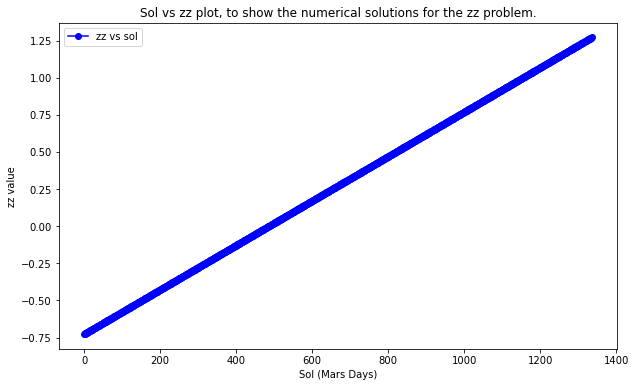

In [12]:
import matplotlib.pyplot as plt

def numerical_method_zz_zanom():
    """purpose of this function is, through numerical method, to define zz values based on the sol input to use in the reversal of the sol_to_ls function."""
    year_day = 668.6
    peri_day = 485.35
    sol_test_values = range(0, int(year_day) *2, 1)
    sol_zz_dict = {}
    sol_zanom_dict = {}
    for sol in sol_test_values:
        zz = (sol-peri_day) /year_day
        sol_zz_dict[f"{sol}"] = zz
        zanom = 2* math.pi * (zz - round(zz))
        sol_zanom_dict[f"{sol}"] = zanom
        ls = sol_to_ls(sol) # rounded ls 
        ls_zz_dict[f"{round(ls,1)}"] = zz
        
    
    return sol_zz_dict, sol_zanom_dict, ls_zz_dict



def match_zz_for_ls(ls):
    """Matches the zz to the given ls using numerical method."""
    sol_zz_dict, sol_zanom_dict, ls_zz_dict = numerical_method_zz_zanom()
    for ls in ls_zz_dict:
        if int(ls) == ls_zz_dict.keys():
            zz_value_for_ls = ls_zz_dict.get(ls)
    
    return zz_value_for_ls
    
    

def sol_vs_zz_plot(dictionary):
    """Plots sol value vs zz for visualisation"""
    sol_zz_dict, sol_zanom_dict, ls_zz_dict = numerical_method_zz_zanom()
    sol_values = list(sol_zz_dict.keys())
    zz_values = list(sol_zz_dict.values())
    
    sol_values = [int(sol) for sol in sol_values]

    plt.figure(figsize = (10,6))
    plt.plot(sol_values, zz_values, marker="o", linestyle="-", color="blue",label="zz vs sol")

    plt.xlabel("Sol (Mars Days)")
    plt.ylabel("zz value")
    plt.title("Sol vs zz plot, to show the numerical solutions for the zz problem.")
    plt.legend()
    
    plt.show()
    
sol_vs_zz_plot(sol_zz_dict)

In [36]:
def sol_vs_zanom_plot(sol_zanom_dict):
    
    sol_values_2 = list(sol_zanom_dict.keys())#error due to changing from a dictionary, this is leftover code to be corrected.
    zanom_values = list(sol_zanom_dict.values())
    
    zanom_values = [float(zanom) for zanom in zanom_values]
    sol_values_2 = [int(sol) for sol in sol_values_2]
    
    plt.figure(figsize=(10,6))
    plt.plot(sol_values_2, zanom_values, marker="o", linestyle="-", color="blue",label="zz vs sol")

    plt.xlabel("Sol (Mars Days)")
    plt.ylabel("zanom value")
    plt.title("Sol vs zanom plot, to show the numerical solutions for the zz problem.")
    plt.legend()
    
    plt.show()   

sol_vs_zanom_plot(sol_zanom_dict)

AttributeError: 'list' object has no attribute 'keys'

# Reversing the code so Earth date can be calculated using Mars date, so this can be input into links to gather the data for the correct times matching the NOMAD data.

In [37]:
import math
from datetime import datetime, timedelta
import numpy as np

#can reverse the keplerian equation:

# def numerical_method_zz_zanom():
#     """purpose of this function is, through numerical method, to define zz values based on the sol input to use in the reversal of the sol_to_ls function."""
#     year_day = 668.6
#     peri_day = 485.35
#     sol_test_values = range(0, int(year_day) *2, 1)
#     sol_zz_dict = {}
#     sol_zanom_dict = {}
#     ls_zz_dict = {}
#     for sol in sol_test_values:
#         zz = (sol-peri_day) /year_day
#         sol_zz_dict[f"{sol}] = zz
#         zanom = 2* math.pi * (zz - round(zz))
#         sol_zanom_dict[f"{sol}"] = zanom
#         ls = sol_to_ls(sol)
#         ls_zz_dict[f"{ls}"] = zz
        
    
#     return sol_zz_dict, sol_zanom_dict, ls_zz_dict
                    
def numerical_method_zz_zanom():
    """purpose of this function is, through numerical method, to define zz values based on the sol input to use in the reversal of the sol_to_ls function."""
    year_day = 668.6
    peri_day = 485.35
    sol_test_values = range(0, int(year_day) *2, 1)
    sol_zz_dict = []
    sol_zanom_dict = []
    ls_zz_dict = []
    for sol in sol_test_values:
        zz = (sol-peri_day) /year_day
        sol_zz_dict.append((sol,zz))
        zanom = 2* math.pi * (zz - round(zz))
        sol_zanom_dict.append((sol,zanom))
        ls = sol_to_ls(sol)
        ls_zz_dict.append((round(ls,1),zz))
        
    
    return sol_zz_dict, sol_zanom_dict, ls_zz_dict

sol_zz_dict, sol_zanom_dict, ls_zz_dict = numerical_method_zz_zanom()
#print(ls_zz_dict)


def match_zz_for_ls(ls):
    """Matches the zz to the given ls using numerical method."""
    year_day = 668.6
    sol_zz_dict, sol_zanom_dict, ls_zz_dict = numerical_method_zz_zanom()
    for lsvalue,zzvalue in ls_zz_dict:
        
        if lsvalue == ls:
            print(f"Value found: ls value{ls} corresponds to zz value {zzvalue}")
            return zzvalue
        
        return None
    
    
    
#         ls_zz_tuple = (int(ls_zz_dict_keys),ls_zz_dict.values())
        
        
        
#     for ls in range(0, int(year_day) *2, 1):
#         if int(ls) == ls_zz_dict.keys():
#             zz_value_for_ls = ls_zz_dict.get(ls)
    
#     return zz_value_for_ls

   # matched_sol_to_ls = {k1: k2 for k1, v1 in sol_zz_dict for k2, v2 in ls_zz_dict if v1==v2}


# MATCHED_zz = match_zz_for_ls(ls)
# print(match_zz_for_ls)


    #testing sol values every 10 days up to 2 martian years
def ls_to_sol(ls):
    year_day = 668.6
    peri_day = 485.35
    e_ellip = 0.09340
    timeperi = 1.90258341759902  # Ls at perihelion = 250.99
    deg2rad = math.pi / 180.0
    
    ls_rad = ls * deg2rad
    if ls_rad < 0:
        ls_rad += 2* math.pi
    if ls_rad > (2*math.pi):
        lsrad -= (2*math.pi)
        
    zteta = ls_rad + timeperi
    #calculating true anomaly^
    
    
#     if zteta < 0:
#         zteta += 2.0 *math.pi 
#     if zteta > 2.0 *math.pi: #changing range to 0 to 2pi radians
#         zteta -= 2.0 * math.pi
    
    #solving kepler's equation, backwards.
    #zx0 = 2.0 * math.atan(math.sqrt((1.0 - e_ellip) / (1.0 + e_ellip)) * math.tan(zteta / 2.0))
    #if ls>180.0:
     #   zx0 = -zx0
    zx0 = math.atan(math.tan(zteta/2) / (math.sqrt(((1. + e_ellip) / (1. - e_ellip))))) * 2
    
   # zanom = float(2. * math.pi * (zz - round(zz)))

    print(type(match_zz_for_ls(ls)))
    #zz = type(match_zz_for_ls(ls)
    #zz = (sol - peri_day) / year_day
    sol = (zz * year_day) + peri_day
    
    
    #zanom = zx0 - e_ellip *math.sin(zx0)
    0
    #through numerical method:
    
    
    return sol

test_sol = ls_to_sol(322)

#This is the main problem I have been having: finding zz through numerical method. 

<class 'NoneType'>


NameError: name 'zz' is not defined

In [38]:
import math
import numpy as np
#need sol_zz
#need ls_zz
#map them to eachotehr
def numerical_method_zz_ls():
    """purpose of this function is, through numerical method, to define zz values based on the sol input to use in the reversal of the sol_to_ls function."""
    year_day = 668.6
    peri_day = 485.35
    sol_test_values = np.arange(0, int(year_day) *2, 0.1)
    
    sol_zz_dict = {}
    sol_zanom_dict = {}
    ls_zz_dict = {}
    
    for sol in sol_test_values:
        zz = (sol-peri_day) /year_day
        sol_zz_dict[f"{sol}"] = zz
        zz = float(zz)
        zanom = float(2* math.pi * (zz - round(zz)))
        sol_zanom_dict[f"{sol}"] = zanom
        
        ls = sol_to_ls(sol)
        print(ls)
        ls_zz_dict[f"{ls}"] = zz    
    
    return sol_zz_dict, sol_zanom_dict, ls_zz_dict

sol_zz_dict, sol_zanom_dict, ls_zz_dict = numerical_method_zz_ls()
print(ls_zz_dict)

6.293556149881151e-05
0.05134584369971988
0.1026203940422501
0.15388659121899745
0.20514443986317774
0.256393944612116
0.30763511010652145
0.3588679409908945
0.410092441913463
0.4613086175259537
0.5125164724839353
0.5637160114464369
0.6149072390761517
0.6660901600396023
0.71726477900653
0.7684311006506961
0.8195891296492082
0.8707388706827232
0.9218803284357147
0.9730135075959131
1.0241384128548912
1.0752550489076438
1.1263634204525879
1.1774635321919575
1.2285553888311795
1.279638995079498
1.3307143556494896
1.3817814752571667
1.4328403586222558
1.4838910104677152
1.534933435520142
1.5859676385096062
1.6369936241693965
1.6880113972365673
1.7390209624513158
1.7900223245575153
1.8410154883023349
1.8920004584362253
1.9429772397133143
1.9939458368909104
2.0449062547297823
2.095858497994095
2.146802571451221
2.1977384798721444
2.2486662280310434
2.2995858207054165
2.3504972626761713
2.401400558727435
2.452295713646782
2.5031827322249924
2.554061619256206
2.6049323795378054
2.65579501787039

64.7321185355199
64.77701422147413
64.82190912345062
64.8668032471128
64.91169659812383
64.9565891821471
65.00148100484556
65.04637207188243
65.09126238892068
65.13615196162336
65.18104079565337
65.22592889667357
65.27081627034671
65.31570292233556
65.3605888583029
65.40547408391133
65.45035860482331
65.49524242670147
65.54012555520823
65.58500799600607
65.62988975475733
65.67477083712429
65.71965124876914
65.76453099535415
65.8094100825415
65.85428851599322
65.89916630137137
65.94404344433791
65.98891995055483
66.03379582568398
66.07867107538725
66.12354570532634
66.16841972116309
66.21329312855907
66.25816593317604
66.3030381406756
66.3479097567192
66.39278078696834
66.43765123708455
66.4825211127292
66.52739041956367
66.57225916324927
66.61712734944719
66.66199498381877
66.7068620720251
66.75172861972742
66.79659463258677
66.84146011626413
66.8863250764206
66.93118951871716
66.9760534488147
67.02091687237409
67.06577979505614
67.11064222252176
67.15550416043162
67.20036561444653
67.

353.9410333947437
353.88873288156395
353.8364234888365
353.7841052124463
353.73177804828333
353.67944199224235
353.6270970402229
353.57474318812984
353.5223804318726
353.47000876736587
353.4176281905292
353.3652386972869
353.3128402835688
353.26043294530916
353.20801667844785
353.1555914789292
353.10315734270273
353.05071426572346
352.9982622439509
352.9458012733499
352.89333134989033
352.84085246954714
352.7883646283006
352.7358678221358
352.68336204704303
352.63084729901783
352.57832357406085
352.5257908681779
352.47324917738
352.4206984976831
352.36813882510876
352.3155701556833
352.2629924854388
352.210405810412
352.15781012664536
352.1052054301861
352.05259171708724
351.9999689834067
351.9473372252078
351.8946964385591
351.8420466195346
351.78938776421353
351.73671986868044
351.6840429290252
351.6313569413432
351.57866190173496
351.5259578063065
351.4732446511693
351.42052243244
351.3677911462409
351.3150507886997
351.2623013559493
351.20954284412824
351.1567752493806
351.10399856

263.9180745483364
263.9830141855868
264.0479509895844
264.1128849466011
264.17781604291616
264.24274426481554
264.30766959859244
264.3725920305471
264.4375115469868
264.5024281342262
264.5673417785869
264.6322524663979
264.69716018399527
264.76206491772257
264.8269666539306
264.89186537897734
264.9567610792284
265.0216537410567
265.0865433508425
265.15142989497366
265.2163133598455
265.28119373186087
265.3460709974302
265.41094514297157
265.4758161549106
265.5406840196806
265.6055487237225
265.67041025348516
265.73526859542505
265.80012373600636
265.86497566170124
265.92982435898955
265.9946698143592
266.0595120143058
266.12435094533316
266.18918659395285
266.2540189466844
266.31884799005564
266.38367371060224
266.448496094868
266.51331512940493
266.57813080077307
266.6429430955408
266.7077520002845
266.77255750158906
266.83735958604746
266.90215824026103
266.96695345083947
267.03174520440075
267.0965334875715
267.16131828698644
267.2260995892889
267.2908773811308
267.3556516491724
267

331.76939880916996
331.8255951826606
331.8817815422965
331.93795788917527
331.99412422440463
332.0502805491026
332.1064268643975
332.1625631714277
332.21868947134163
332.27480576529797
332.33091205446556
332.38700834002327
332.4430946231602
332.49917090507546
332.5552371869781
332.61129347008733
332.6673397556326
332.72337604485307
332.7794023389981
332.83541863932703
332.89142494710904
332.9474212636234
333.00340759015944
333.05938392801625
333.11535027850294
333.1713066429383
333.2272530226515
333.2831894189812
333.3391158332759
333.3950322668943
333.4509387212046
333.50683519758496
333.5627216974234
333.6185982221176
333.67446477307516
333.73032135171326
333.786167959459
333.84200459774934
333.89783126803064
333.95364797175915
334.00945471040063
334.06525148543085
334.12103829833507
334.17681515060815
334.23258204375463
334.28833897928865
334.34408595873396
334.399822983624
334.4555500555017
334.5112671759196
334.5669743464395
334.62267156863334
334.678358844082
334.7340361743762
33

68.27691005954269
68.32176125581229
68.36661211535342
68.41146264382589
68.45631284688943
68.50116273020397
68.54601229942912
68.59086156022472
68.63571051825042
68.68055917916585
68.72540754863074
68.77025563230468
68.81510343584732
68.85995096491817
68.90479822517678
68.9496452222828
68.9944919618957
69.03933844967499
69.08418469128007
69.12903069237043
69.17387645860555
69.21872199564484
69.26356730914769
69.30841240477345
69.35325728818151
69.3981019650312
69.44294644098188
69.48779072169287
69.53263481282346
69.57747872003286
69.62232244898038
69.66716600532536
69.71200939472695
69.75685262284435
69.80169569533676
69.8465386178635
69.89138139608372
69.93622403565651
69.9810665422411
70.02590892149655
70.07075117908215
70.11559332065698
70.16043535188012
70.20527727841069
70.2501191059078
70.29496084003058
70.33980248643812
70.38464405078946
70.42948553874373
70.47432695595987
70.51916830809712
70.56400960081449
70.60885083977097
70.65369203062565
70.69853317903748
70.7433742906657

337.17401882071357
337.1187773607797
337.06352603487073
337.008264840992
336.95299377715776
336.89771284139107
336.842422031724
336.7871213461976
336.7318107828615
336.67649033977466
336.6211600150048
336.56581980662884
336.5104697127323
336.45510973141006
336.3997398607658
336.3443600989124
336.28897044397166
336.23357089407443
336.1781614473608
336.12274210197984
336.06731285608964
336.0118737078574
335.9564246554598
335.9009656970821
335.84549683091933
335.7900180551752
335.73452936806285
335.67903076780453
335.62352225263186
335.5680038207856
335.51247547051554
335.45693720008103
335.4013890077507
335.34583089180234
335.29026285052305
335.2346848822092
335.1790969851666
335.1234991577104
335.06789139816516
335.01227370486464
334.9566460761521
334.9010085103801
334.84536100591095
334.78970356111597
334.7340361743762
334.678358844082
334.6226715686333
334.5669743464395
334.5112671759195
334.4555500555017
334.39982298362406
334.344085958734
334.2883389792886
334.2325820437546
334.1768

257.21672171039353
257.28187849808063
257.34703389775575
257.4121878951492
257.477340475995
257.5424916260299
257.6076413309952
257.6727895766352
257.737936348698
257.8030816329356
257.86822541510315
257.9333676809604
257.99850841626994
258.0636476067989
258.12878523831824
258.193921296602
258.25905576742946
258.32418863658245
258.3893198898479
258.4544495130163
258.51957749188216
258.5847038122444
258.6498284599056
258.71495142067306
258.780072680358
258.84519222477553
258.91031003974604
258.975426111093
259.04054042464514
259.10565296623525
259.1707637217003
259.2358726768823
259.3009798176271
259.3660851297855
259.4311885992129
259.4962902117686
259.5613899533177
259.6264878097287
259.6915837668757
259.7566778106371
259.82176992689614
259.886860101541
259.95194832046445
260.0170345695643
260.0821188347433
260.1472011019089
260.21228135697385
260.2773595858554
260.34243577447626
260.40750990876427
260.472581974652
260.53765195807745
260.6027198449836
260.6677856213187
260.73284927303

354.72447835985935
354.77663736388894
354.82878755906745
354.88092894959686
354.933061539683
354.98518533353706
355.037300335375
355.08940654941676
355.1415039798876
355.19359263101705
355.24567250703956
355.2977436121941
355.34980595072415
355.40185952687807
355.45390434490827
355.50594040907254
355.5579677236327
355.60998629285524
355.6619961210114
355.7139972123765
355.7659895712311
355.81797320185973
355.8699481085516
355.9219142956007
355.97387176730484
356.025820527967
356.0777605818946
356.12969193339893
356.18161458679634
356.23352854640734
356.2854338165569
356.3373304015746
356.38921830579415
356.44109753355406
356.49296808919655
356.544829977069
356.59668320152304
356.64852776691396
356.70036367760224
356.75219093795226
356.80400955233284
356.8558195251172
356.90762086068275
356.9594135634114
357.01119763768895
357.062973087906
357.11473991845725
357.1664981337413
357.21824773816155
357.2699887361252
357.32172113204405
357.37344493033396
357.4251601354149
357.47686675171127


In [39]:
def convert2julian_from_mars(martian_year, ls):
    jdate_ref = 2.442765667e6  # 19/12/1975 4:00:00, such that Ls=0
    martianyear_ref = 12
    earthday = 86400.0
    marsday = 88775.245
    marsyear = 668.60  # Number of sols in a Martian yearjdate_ref = 2.442765667e6 # Ref julian date Ls= 0 on 1975/12/19
    
    sol = ls_to_sol(ls)
    
    year_offset = martian_year - martianyear_ref
    total_sol = sol + (year_offset * marsyear)
    #adjusting sol based on MY difference
    #sol += year_offset * marsyear 
    
    jdate = jdate_ref + (total_sol * marsday /earthday)
    
    return jdate

In [40]:
def convert2earthdate(jdate): #this code now works perfectly: only issue has been with the zz value
    ref_year = 1968
    ref_jdate = 2.4398565e6  # Julian date for 01/01/1968 00:00:00
    edays = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334] #cumulative days of the year for each month
    
    #total_days = jdate - ref_jdate + 1.0
    #day_exact = total_days : gave 1.75 due to hours not being separate from days.
    total_days = jdate - ref_jdate + 1.0
    whole_days = math.floor(total_days)
    frac_day = total_days - whole_days
    
    hours_exact = frac_day * 24.0
    minutes_exact = (hours_exact - math.floor(hours_exact)) * 60.0
    seconds_exact = (minutes_exact - math.floor(minutes_exact)) *60.0
    
    #year eaxct days:
    year = ref_year
    while whole_days >= 365.0:
        is_leap = (year % 4==0 and year % 100 != 0) or (year % 400 == 0)
        days_in_year =366 if is_leap else 365.0
        if whole_days >= days_in_year:
            whole_days -= days_in_year
            year += 1
        else:
            break
    
    #month and day:
    is_leap = (year % 4==0 and year % 100 != 0) or (year % 400 == 0)
    month_days = edays[:]
    if is_leap:
        for m in range(2, 12):
            month_days[m] += 1 #adjusting for leap year
    
    month = 1 
    while month < 12 and whole_days > month_days[month]:
        month += 1
        
    day_exact = whole_days - month_days[month - 1]
    
    return year, month, day_exact, hours_exact, minutes_exact, seconds_exact
#testing it works correctly:
jdate = convert2julian(2000, 1, 1, 18, 0, 0)
print(jdate)
print(convert2earthdate(jdate))

2451545.25
(2000, 1, 1.0, 18.0, 0.0, 0.0)


In [41]:
def MartianDate_to_EarthDate(martian_year, ls):
    sol = ls_to_sol(ls)
    jdate = convert2julian_from_mars(martian_year, ls)
    earthdate = convert2earthdate(jdate)
    return earthdate

martian_year = 24
ls = 274.4
earthdate = MartianDate_to_EarthDate(martian_year, ls)
#print(f"Martian date: MY{martian_year}, ls{ls}: Earth date: {year}/{month}/{day_exact}, Earth time: {hours_exact}:{minutes_exact}:{seconds_exact}")
print(f"marsdate: {martian_year}, {ls}. Earthdate: {earthdate}")

<class 'NoneType'>


NameError: name 'zz' is not defined